In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

import torchvision.models as models


""" !wget "https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py" -q -O d2l.py
import d2l

import keras """;


In [2]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

# The dataset are sets of images of drivers, carrying out different actions.
### The 10 classes to predict are:
c0: normal driving \
c1: texting - right \
c2: talking on the phone - right \
c3: texting - left \
c4: talking on the phone - left \
c5: operating the radio \
c6: drinking \
c7: reaching behind \
c8: hair and makeup \
c9: talking to passenger 

In [3]:
df = pd.read_csv("src/driver_imgs_list.csv")

# For pilot study, we approach this with binary classification: 
# Normal driving c0 vs not_c0 (designated as c1) 
#df["classname"].loc[df["classname"] != "c0"] = "c1"

print(f'Unique people total: {len(df["subject"].unique())}\n{df["subject"].unique()}\n')

print(f'Unique classes: {np.unique(df["classname"])}\nCounts for each: {np.unique(df["classname"], return_counts=True)[1]}\n')

people = df["subject"].unique()


Unique people total: 26
['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']

Unique classes: ['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
Counts for each: [2489 2267 2317 2346 2326 2312 2325 2002 1911 2129]



In [4]:
#y = df["classname"]
#X = df.drop(columns=["classname"]).copy()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #doesn't stop people being in both train/test



train_idx = np.random.choice(people, 20, replace=False)
test_idx = [x for x in people if (x in train_idx)==False]

train = df[df.subject.isin(train_idx)].copy()
test= df[df.subject.isin(test_idx)].copy()

y_train = train["classname"]
X_train = train.drop(columns=["classname"]).copy()

y_test = test["classname"]
X_test = test.drop(columns=["classname"]).copy()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train.head(5)

(16876, 2) (16876,) (5548, 2) (5548,)


,subject,img
0,p002,img_44733.jpg
1,p002,img_72999.jpg
2,p002,img_25094.jpg
3,p002,img_69092.jpg
4,p002,img_92629.jpg


In [5]:
y_train = y_train.map(lambda x: int(x[1:]))
y_test = y_test.map(lambda x: int(x[1:]))

In [6]:
##classes are similar although not exactly the same as original
print(f'Unique classes train: {np.unique(y_train)}\nCounts for each     : {np.unique(y_train, return_counts=True)[1]}\n')
print(f'Unique classes test : {np.unique(y_test)}\nCounts for each     : {np.unique(y_test, return_counts=True)[1]}\n')


Unique classes train: [0 1 2 3 4 5 6 7 8 9]
Counts for each     : [1920 1694 1749 1775 1762 1738 1761 1504 1398 1575]

Unique classes test : [0 1 2 3 4 5 6 7 8 9]
Counts for each     : [569 573 568 571 564 574 564 498 513 554]



In [7]:
val_img = set(X_test["img"])

In [8]:
classes = list(df.classname.unique())

In [9]:
# import required module
import os
import shutil
# assign directory
directory_train = 'src/imgs/train/'
dest_train = 'src/train_m'

dest_train_c0 = 'src/train_m/c0'
dest_train_c1 = 'src/train_m/c1'
dest_train_c2 = 'src/train_m/c2'
dest_train_c3 = 'src/train_m/c3'
dest_train_c4 = 'src/train_m/c4'
dest_train_c5 = 'src/train_m/c5'
dest_train_c6 = 'src/train_m/c6'
dest_train_c7 = 'src/train_m/c7'
dest_train_c8 = 'src/train_m/c8'
dest_train_c9 = 'src/train_m/c9'

dest_val_c0 = 'src/val_m/c0'
dest_val_c1 = 'src/val_m/c1'
dest_val_c2 = 'src/val_m/c2'
dest_val_c3 = 'src/val_m/c3'
dest_val_c4 = 'src/val_m/c4'
dest_val_c5 = 'src/val_m/c5'
dest_val_c6 = 'src/val_m/c6'
dest_val_c7 = 'src/val_m/c7'
dest_val_c8 = 'src/val_m/c8'
dest_val_c9 = 'src/val_m/c9'

from distutils.dir_util import copy_tree


#copy_tree(directory_train, dest_train)


'''for file in os.listdir(dest_train_c0):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c0,file), dest_val_c0)

for file in os.listdir(dest_train_c1):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c1,file), dest_val_c1)

for file in os.listdir(dest_train_c2):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c2,file), dest_val_c2)

for file in os.listdir(dest_train_c3):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c3,file), dest_val_c3)

for file in os.listdir(dest_train_c4):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c4,file), dest_val_c4)

for file in os.listdir(dest_train_c5):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c5,file), dest_val_c5)

for file in os.listdir(dest_train_c6):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c6,file), dest_val_c6)

for file in os.listdir(dest_train_c7):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c7,file), dest_val_c7)

for file in os.listdir(dest_train_c8):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c8,file), dest_val_c8)

for file in os.listdir(dest_train_c9):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c9,file), dest_val_c9)''';

In [10]:
# load resnet18:
from torchvision.models import ResNet18_Weights
resnet18 = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all the pre-trained layers
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = 10
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
train_dataset = ImageFolder('src/train_m', transform=transform)
val_dataset = ImageFolder('src/val_m', transform=transform)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

In [11]:
from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in tqdm(range(num_epochs)):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)
        training_loss.append(train_loss)
        

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)
        testing_loss.append(val_loss)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


In [13]:
model = resnet18

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device avaiable: {device}')
model.to(device)

Device avaiable: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
training_loss = []
testing_loss = []

In [15]:
# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

 20%|██        | 1/5 [03:59<15:56, 239.08s/it]

Epoch [1/5], train loss: 0.6742, train acc: 0.7950, val loss: 1.3091, val acc: 0.5804


 40%|████      | 2/5 [07:55<11:52, 237.41s/it]

Epoch [2/5], train loss: 0.2919, train acc: 0.9163, val loss: 1.3991, val acc: 0.5789


 60%|██████    | 3/5 [11:52<07:54, 237.28s/it]

Epoch [3/5], train loss: 0.2298, train acc: 0.9364, val loss: 1.4636, val acc: 0.5699


 80%|████████  | 4/5 [15:49<03:57, 237.19s/it]

Epoch [4/5], train loss: 0.2021, train acc: 0.9442, val loss: 1.6289, val acc: 0.5580


100%|██████████| 5/5 [19:46<00:00, 237.22s/it]

Epoch [5/5], train loss: 0.1819, train acc: 0.9473, val loss: 1.5052, val acc: 0.5661


In [16]:
# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]/home/xannadoo/miniconda3/envs/AML_exam/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 10%|█         | 1/10 [04:07<37:06, 247.36s/it]

Epoch [1/10], train loss: 0.0587, train acc: 0.9844, val loss: 0.9735, val acc: 0.7183


 20%|██        | 2/10 [08:17<33:10, 248.79s/it]

Epoch [2/10], train loss: 0.0032, train acc: 0.9993, val loss: 0.8961, val acc: 0.7478


 30%|███       | 3/10 [12:25<28:59, 248.46s/it]

Epoch [3/10], train loss: 0.0010, train acc: 1.0000, val loss: 0.8847, val acc: 0.7498


 40%|████      | 4/10 [16:32<24:48, 248.05s/it]

Epoch [4/10], train loss: 0.0007, train acc: 1.0000, val loss: 0.8502, val acc: 0.7568


 50%|█████     | 5/10 [20:41<20:41, 248.33s/it]

Epoch [5/10], train loss: 0.0005, train acc: 1.0000, val loss: 0.8331, val acc: 0.7626


 60%|██████    | 6/10 [24:50<16:33, 248.47s/it]

Epoch [6/10], train loss: 0.0004, train acc: 1.0000, val loss: 0.8203, val acc: 0.7677


 70%|███████   | 7/10 [28:58<12:25, 248.43s/it]

Epoch [7/10], train loss: 0.0003, train acc: 1.0000, val loss: 0.8219, val acc: 0.7648


 80%|████████  | 8/10 [33:07<08:16, 248.44s/it]

Epoch [8/10], train loss: 0.0002, train acc: 1.0000, val loss: 0.8410, val acc: 0.7639


 90%|█████████ | 9/10 [37:24<04:11, 251.16s/it]

Epoch [9/10], train loss: 0.0002, train acc: 1.0000, val loss: 0.8365, val acc: 0.7624


100%|██████████| 10/10 [41:34<00:00, 249.45s/it]

Epoch [10/10], train loss: 0.0002, train acc: 1.0000, val loss: 0.8104, val acc: 0.7682


In [17]:
torch.save(model.state_dict(), 'model_v2.pt')

model = resnet18
model.load_state_dict(torch.load('model_v2.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
import matplotlib.pyplot as plt
from multiprocessing import Pool

def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index



def get_random_images(num, data_dir, y):
    data = ImageFolder(data_dir, transform=transform)
    classes = y
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    pool = Pool()
    dataiter = pool.map(iter,loader)
    images = []
    labels = []
    for it in dataiter:
        i, l = it
        images.append(i)
        labels.append(l)
    return images, labels

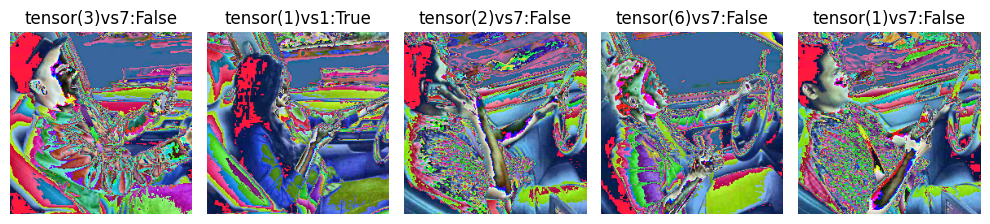

In [36]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, 'src/val_m', y_test)

fig, ax =plt.subplots(1,5, figsize=(10,10))
ax = ax.flatten()

for ii in range(len(images[0])):
    image = to_pil(images[0][ii,])
    index = predict_image(image)
    r = int(labels[0][ii]) == index
    ax[ii].set_title(str(labels[0][ii]) + 'vs' + str(index) + ":" + str(r))
    ax[ii].axis('off')
    
    ax[ii].imshow(image)

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

105


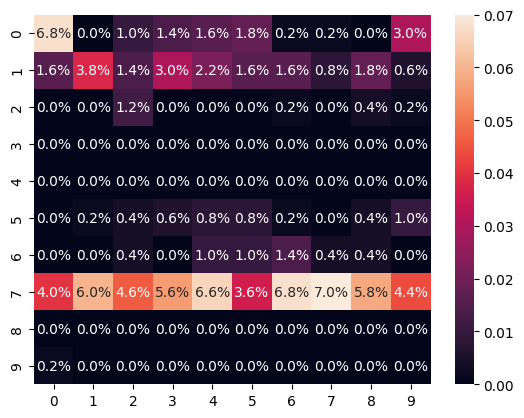

In [37]:
np.random.seed(42)
images, labels = get_random_images(500, 'src/val_m', y_test)
res = []
for ii in range(len(images[0])):
    image = to_pil(images[0][ii,])
    index = predict_image(image)
    r = int(labels[0][ii]) == index
    res.append(index)

print(sum([1 if i == j else 0 for i,j in zip(res, labels[0])]))

cm = confusion_matrix(res, labels[0])

sns.heatmap(cm/len(res), annot=True, fmt='.1%');

In [38]:
labels

[tensor([2, 9, 1, 5, 7, 4, 4, 1, 1, 5, 4, 6, 5, 3, 8, 9, 1, 9, 2, 9, 7, 2, 0, 0,
         0, 1, 8, 2, 8, 7, 5, 1, 6, 1, 4, 6, 1, 6, 8, 9, 9, 3, 1, 6, 7, 8, 0, 0,
         0, 9, 4, 4, 9, 4, 0, 0, 8, 5, 8, 7, 6, 3, 9, 4, 6, 1, 0, 8, 7, 6, 2, 2,
         2, 1, 4, 7, 8, 4, 6, 8, 1, 0, 9, 3, 5, 9, 3, 7, 0, 3, 6, 6, 8, 4, 4, 7,
         7, 6, 7, 5, 7, 5, 2, 1, 4, 4, 0, 4, 9, 7, 2, 2, 5, 4, 7, 4, 6, 2, 5, 5,
         2, 4, 3, 4, 1, 0, 3, 3, 3, 0, 2, 0, 4, 6, 1, 2, 3, 0, 8, 5, 3, 0, 1, 4,
         5, 5, 4, 9, 1, 6, 7, 3, 2, 5, 0, 5, 9, 5, 3, 9, 5, 5, 4, 3, 1, 2, 2, 1,
         4, 5, 4, 8, 8, 7, 3, 6, 6, 8, 4, 0, 1, 5, 4, 8, 4, 7, 7, 2, 4, 2, 8, 2,
         2, 7, 9, 2, 0, 2, 6, 4, 4, 2, 0, 0, 9, 8, 2, 1, 5, 3, 0, 7, 2, 5, 0, 0,
         0, 0, 7, 6, 2, 9, 8, 5, 6, 4, 4, 6, 2, 7, 6, 4, 2, 1, 7, 4, 4, 2, 3, 8,
         5, 5, 4, 0, 9, 3, 3, 0, 8, 8, 8, 4, 7, 2, 6, 0, 9, 1, 5, 9, 9, 4, 5, 8,
         9, 6, 3, 4, 0, 6, 1, 8, 1, 0, 4, 3, 7, 5, 9, 5, 0, 0, 6, 6, 0, 1, 2, 0,
         1, 1, 1, 6, 4, 7, 3